# Gradient Boost
It turns out the cms translation software we are using to push a scikit-learn BDT back to a TMVA one was designed for Gradient Boost only. While we did a translation as an experiment for the Ada boost we used, we should try this guy out as well to see what happens and see if it is "better".

## Initalization

In [1]:
from bdt_training_scikit_tools import load_default_samples, default_training_variable_list, \
    test_train_samples, prep_samples, default_training, calc_performance
import matplotlib.pyplot as plt
plt.rc('font', size=14)
from matplotlib.colors import LogNorm
import pandas as pd
import numpy as np
import multiprocessing as mp
import itertools
from sklearn.ensemble import GradientBoostingClassifier
import mlglue.tree

In [2]:
default_cut_Lxy = 1250
default_cut_Lz = 3500
eta_seperator_cut = 1.4
def trim_sample(sample, cut_Lxy = default_cut_Lxy, cut_Lz = default_cut_Lz):
    '''Trim lxy and lz cuts for a sample'''
    return sample[((abs(sample.JetEta) > eta_seperator_cut) & (sample.mc_Lz*1000 > cut_Lz)) | ((abs(sample.JetEta) <= eta_seperator_cut) & (sample.mc_Lxy*1000 > cut_Lxy))]

def trim_samples(all_events):
    '''Trim default lxy and lz cuts for a tuple of (mj, bib, signal) samples'''
    return (all_events[0], all_events[1], trim_sample(all_events[2]))

def load_trimmed_sample(jobNo):
    '''Load and trim a sample from a job, and record it in our sample archive'''
    print ('Job {0}:'.format(jobNo))
    all_events_all = load_default_samples(jobNo)
    all_events = trim_samples(all_events_all)
    print (" ", [len(e.index) for e in all_events])
    
    return all_events

## Load the data

In [3]:
%%time
input_events = load_trimmed_sample(106)

Job 106:
  BIB: 800000 events
  Multijet: 800000 events
  Signal: 800000 events
  [800000, 800000, 504190]
Wall time: 32.5 s


## Training Setup

In [4]:
training_variables = ['EnergyDensity',
 'BIBDeltaTimingM',
 'JetPt',
 'HadronicLayer1Fraction',
 'ShowerCenter',
 'JetLat',
 'FirstClusterRadius',
 'JetLong',
 'MaxTrackPt',
 'PredictedLxy',
 'BIBDeltaTimingP',
 'PredictedLz',
 'SumPtOfAllTracks']

In [11]:
ones = np.ones(10)
zeros = np.zeros(10)
r = np.array((zeros, ones, zeros)).T
r[2]

array([ 0.,  1.,  0.])

In [12]:
# Prep the samples for training - limit number of events, etc.
def prep_samples_mc (bib, mj, sig, nEvents = 0, training_variable_list = default_training_variable_list):
    '''Convert the input data frames into samples that are ready to feed to the
    scikitlearn infrastructure.
    
    Args
        bib - the bib dataframe
        mj - the mj dataframe
        sig - the signal dataframe
        nEvents - how many events to prepare. 0 means use everything.
        
    Returns
        events - all the events appended in a dataframe
        event_classes - class array with each row a 1 in one column: (s, mj, bib)
        training_weight - the weights from the Weight column
        evaluation_weight - the xsection * mc weight
    '''
    # Append the three inputs, as they are what we will be fitting against.
    # At the same time (to keep things straight) build the class sigle array.
    s_bib = bib if nEvents == 0 else bib[:nEvents]
    ones = np.ones(len(s_bib.index))
    zeros = np.zeros(len(s_bib.index))
    s_bib_class = pd.DataFrame(np.array((zeros, zeros, ones)).T, columns=['HSS', 'MJ', 'BIB'], dtype = 'int64')
    
    s_mj = mj if nEvents == 0 else mj[:nEvents]
    ones = np.ones(len(s_mj.index))
    zeros = np.zeros(len(s_mj.index))
    s_mj_class = pd.DataFrame(np.array((zeros, ones, zeros)).T, columns=['HSS', 'MJ', 'BIB'], dtype = 'int64')
    
    s_sig = sig if nEvents == 0 else sig[:nEvents]
    ones = np.ones(len(s_sig.index))
    zeros = np.zeros(len(s_sig.index))
    s_sig_class = pd.DataFrame(np.array((ones, zeros, zeros)).T, columns=['HSS', 'MJ', 'BIB'], dtype = 'int64')
    
    all_events = s_bib.append(s_mj, ignore_index=True)
    all_events = all_events.append(s_sig, ignore_index=True)
    
    all_events_class = s_bib_class.append(s_mj_class, ignore_index=True)
    all_events_class = all_events_class.append(s_sig_class, ignore_index=True)

    return (all_events.loc[:,training_variable_list], all_events_class, all_events.Weight, all_events.WeightMCEvent*all_events.WeightXSection)


In [17]:
%%time
# Split into testing and training samples
train, test = test_train_samples(input_events)

# Prep samples for training
all_events, all_events_class, training_weight, evaluation_weight = prep_samples(train[0], train[1], train[2], training_variable_list=training_variables)

Wall time: 2.71 s


In [18]:
all_events_class

,Class
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Training
So a simple training to see how this works

In [19]:
def gradient_training (events, events_weight, events_class):
    '''Given samples prepared, run the default "best" training we know how to run.
    
    Args:
        events - A DF with an entry for every event, with all columns to be trained on
        events_weight - weight assigned to each event (None if no weight is to be used)
        events_class - the training class (0, 1, 2 for bib, mj, and signal)
        min_leaf_fraction - fraction of sample that can be in each leaf. Defaults to 1%
        
    Returns
        bdt - A trained boosted decision tree
    '''
    bdt = GradientBoostingClassifier()
    
    bdt.fit(events, events_class, sample_weight = events_weight)
    
    # The BDT is sent back for use
    return bdt

In [20]:
%%time
bdt = gradient_training(all_events, training_weight, all_events_class)

C:\Users\gordo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 27min 29s


In [21]:
for i in range(0,10):
    print (bdt.eval(all_events[i,:]))

AttributeError: 'GradientBoostingClassifier' object has no attribute 'eval'

In [8]:
calc_performance(bdt, test, training_variables=training_variables)

{'BIBBack': 191943104.5314537,
 'BIBEff': 0.5587998577498269,
 'BIBSsqrtB': 10.774591717872303,
 'BIBTotalCount': 267135,
 'BIBTotalWeight': 267135.0,
 'BIBinBIB': 149275.0,
 'BIBinHSS': 12081.0,
 'BIBinMJ': 105779.0,
 'HSSBack': 28370528.605109442,
 'HSSEff': 0.9842896378335547,
 'HSSSsqrtB': 31.017952900099445,
 'HSSTotalCount': 167851,
 'HSSTotalWeight': 167851.0,
 'HSSinBIB': 1165.0,
 'HSSinHSS': 165214.0,
 'HSSinMJ': 1472.0,
 'MJBack': 107251.0,
 'MJEff': 0.7347801486425272,
 'MJSsqrtB': 1863656.9468193203,
 'MJTotalCount': 266785,
 'MJTotalWeight': 830633099.3287433,
 'MJinBIB': 191941939.5314537,
 'MJinHSS': 28358447.605109442,
 'MJinMJ': 610332712.192177}

In [68]:
bdtGeneral = mlglue.tree.BDTsklearn(bdt, list(all_events.columns), ['BIB', 'MJ', 'Signal'])
bdtGeneral.to_tmva("training_106_test_2.xml")

In [42]:
events = np.array(all_events)
for i in range(0,10):
    print (bdt.predict_proba(events[i,:].reshape(1,-1)))

[[ 0.83908108  0.02301073  0.13790818]]
[[  9.96303587e-01   2.70790704e-03   9.88506021e-04]]
[[ 0.99188967  0.00503917  0.00307116]]
[[ 0.43743812  0.55980127  0.00276061]]
[[ 0.45021148  0.54164344  0.00814508]]
[[ 0.63191713  0.05814198  0.30994088]]
[[ 0.97635733  0.00505682  0.01858585]]
[[ 0.98661825  0.00670284  0.00667892]]
[[ 0.98357358  0.00812758  0.00829884]]
[[ 0.98152436  0.00466383  0.01381182]]


In [43]:
predictions = bdt.predict_proba(events)

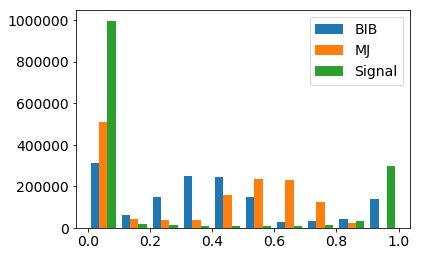

In [51]:
fig = plt.figure()
plt.hist(predictions, label=('BIB', 'MJ', 'Signal'))
plt.legend()
plt.show()

In [58]:
sig = all_events[all_events_class.Class==2]
predictions = bdt.predict_proba(sig)

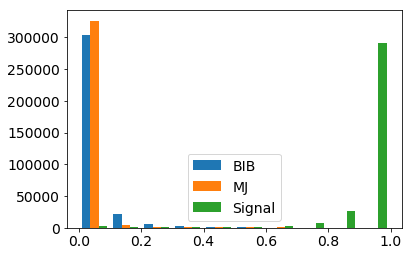

In [59]:
fig = plt.figure()
plt.hist(predictions, label=('BIB', 'MJ', 'Signal'))
plt.legend()
plt.show()

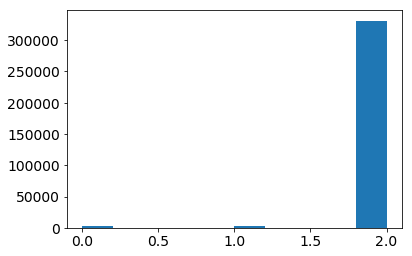

In [60]:
pred_class = bdt.predict(sig)
fig = plt.figure()
plt.hist(pred_class)
plt.show()

In [63]:
sig

,EnergyDensity,BIBDeltaTimingM,JetPt,HadronicLayer1Fraction,ShowerCenter,JetLat,FirstClusterRadius,JetLong,MaxTrackPt,PredictedLxy,BIBDeltaTimingP,PredictedLz,SumPtOfAllTracks
1066080,0.002594,21.44660,406.7280,0.831321,1232.0,0.652344,3040,0.820312,0.000000,2016.420,10.23040,1494.2500,0.000000
1066081,0.000660,36.55420,208.3140,-0.001131,3936.0,0.371094,5440,0.322266,0.000000,3293.990,8.81774,3404.0600,0.000000
1066082,0.005432,6.80703,160.8820,0.151806,1064.0,0.777344,4992,0.820312,0.000000,1043.400,38.70270,4139.8000,0.000000
1066083,0.001572,24.66940,218.9320,0.724941,1296.0,0.488281,3296,0.832031,0.000000,2106.880,10.13050,1962.4600,0.000000
1066084,0.009766,9.41108,168.8610,0.043590,1120.0,0.371094,5088,0.025024,0.000000,1269.280,41.90520,4506.6300,0.000000
1066085,0.002869,9.28139,398.9510,0.227019,2112.0,0.589844,4672,0.964844,0.000000,2353.730,34.30250,3275.0900,0.000000
1066086,0.000973,22.19960,476.0710,0.004157,1512.0,0.859375,3136,0.390625,1.644360,2678.260,16.36650,716.2390,1.644360
1066087,0.000286,107.99100,49.9197,0.503842,1536.0,0.917969,5312,0.867188,0.000000,2407.120,77.33310,4104.5800,0.000000
1066088,0.001183,53.88100,165.0470,0.123994,1784.0,0.875000,4864,0.347656,0.000000,2614.010,28.17120,3465.0700,0.000000
1066089,0.000881,15.78050,261.6910,0.025364,2368.0,0.628906,3872,0.664062,0.000000,2702.320,32.14090,2447.0200,0.000000


In [65]:
input_events[2].EventNumber

0          11890
2          11752
3          11681
4          11197
5          11197
6          11267
7          11327
8          11866
9          11784
11         11433
12         11997
13         11766
14         11561
15         11333
16         11393
17         11554
18         11477
19         11589
20         11025
21         11151
22         11563
23         11563
24         11891
25         11564
27         11508
28         11898
29         11092
31         11423
32         11511
33         11648
           ...  
117857    190897
117858    190897
117859    190739
117860    190035
117861    190082
117862    190979
117864    190856
117865    190896
117866    190203
117867    190033
117868    190033
117870    190535
117871    190997
117872    190572
117873    190317
117875    190425
117876    190538
117877    190538
117878    190188
117879    190904
117880    190461
117881    190954
117882    190396
117883    190499
117884    190870
117885    190422
117886    190959
117887    1907

In [67]:
events = np.array(sig)
for i in range(0,10):
    print (bdtGeneral.eval(events[i,:].reshape(1,-1)))

[[ 0.3063251   0.25699405  0.43668084]]
[[ 0.31246959  0.2666877   0.42084271]]
[[ 0.27998102  0.2605361   0.45948288]]
[[ 0.33426649  0.27007371  0.39565981]]
[[ 0.29979985  0.26936804  0.43083211]]
[[ 0.29538573  0.25488515  0.44972911]]
[[ 0.33310541  0.25669686  0.41019773]]
[[ 0.2975221   0.26097956  0.44149834]]
[[ 0.30173379  0.25395437  0.44431184]]
[[ 0.33174256  0.25465123  0.4136062 ]]
